# DRIVE VERİ SETİ ÜZERİNDE U-NET MİMARİSİ İLE SEGMENTASYON

## VERİ ÖN İŞLEME (İLK VERİ ÖN İŞLEME ADIMI)

*   Veri Arttırma
*   Resize işlemi
*   '.tif, .gif' uzantılı verileri '.jpg' dönüştürme



In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import( HorizontalFlip,
    VerticalFlip,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    Rotate,
    RandomBrightnessContrast,
    GaussNoise,
    RandomCrop,
    HueSaturationValue)

ModuleNotFoundError: No module named 'albumentations'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

def load_data(path):
  train_x= sorted(glob(os.path.join(path,"training","images","*.tif")))
  train_y= sorted(glob(os.path.join(path,"training","1st_manual","*.gif")))
  test_x= sorted(glob(os.path.join(path,"test","images","*.tif")))
  test_y= sorted(glob(os.path.join(path,"test","1st_manual","*.gif")))
  return (train_x,train_y),(test_x,test_y)

In [ ]:
def augment_data(images,masks,save_path,augment=True):
  H,W=512,512
  for idx,(x,y) in tqdm(enumerate(zip(images,masks)),total=len(images)):
    name=x.split("/")[-1].split(".")[0]
    x=cv2.imread(x,cv2.IMREAD_COLOR)
    y=imageio.mimread(y)[0]

    if augment==True:
      aug =HorizontalFlip (p=1.0)
      augmented= aug(image=x, mask=y)
      x1 = augmented["image"]
      y1 = augmented["mask"]

      aug =VerticalFlip (p=1.0)
      augmented = aug(image=x, mask=y)
      x2 =augmented ["image"]
      y2 =augmented ["mask"]

      aug = ElasticTransform(p=1, alpha=120, sigma=120, alpha_affine=120)
      augmented=aug(image=x, mask=y)
      x3 = augmented['image']
      y3 =augmented['mask']

      aug= GridDistortion(p=1)
      augmented= aug(image=x, mask=y)
      x4 = augmented['image']
      y4= augmented['mask']

      aug = OpticalDistortion (p=1, distort_limit=2, shift_limit=0.5)
      augmented=aug(image=x, mask=y)
      x5 = augmented['image']
      y5= augmented['mask']

      aug = Rotate(limit=45)
      augmented = aug(image=x, mask=y)
      x6 = augmented["image"]
      y6 = augmented["mask"]

      # Parlaklık ve Kontrast Değişimi (Random Brightness and Contrast)
      aug = RandomBrightnessContrast(p=1.0)
      augmented = aug(image=x, mask=y)
      x7 = augmented["image"]
      y7 = augmented["mask"]

      # Gaussian Gürültüsü (Gaussian Noise)
      aug = GaussNoise(p=1)
      augmented = aug(image=x, mask=y)
      x8 = augmented["image"]
      y8 = augmented["mask"]

      # Kesme (Random Crop)
      aug = RandomCrop(height=100, width=100)
      augmented = aug(image=x, mask=y)
      x9 = augmented["image"]
      y9 = augmented["mask"]

      # Renk Dönüşümleri (Hue Saturation Value)
      aug = HueSaturationValue(p=1)
      augmented = aug(image=x, mask=y)
      x10 = augmented["image"]
      y10 = augmented["mask"]

      X = [x, x1, x2, x3, x4, x5,x6,x7,x8,x9,x10]
      Y = [y, y1, y2, y3, y4, y5,y6,y7,y8,y9,y10]

    else:
      X=[x]
      Y=[y]

    index=0
    for i,m in zip(X,Y):
      i=cv2.resize(i,(H,W))
      m=cv2.resize(m,(H,W))

      if len(X) ==1 :
        tmp_image_name=f"{name}.jpg"
        tmp_mask_name=f"{name}.jpg"
      else:
        tmp_image_name=f"{name}-{index}.jpg"
        tmp_mask_name=f"{name}-{index}.jpg"


      image_path=os.path.join(save_path,"image",tmp_image_name)
      mask_path=os.path.join(save_path,"mask",tmp_mask_name)

      cv2.imwrite(image_path,i)
      cv2.imwrite(mask_path,m)
      index +=1


In [ ]:
np.random.seed(42)
data_path="/content/drive/MyDrive/bilgisayar-proleri-ders-projesi/DRIVE/"
(train_x,train_y),(test_x,test_y)=load_data(data_path)
print(f"{len(train_x)}, {len(train_y)}")
print(f"{len(test_x)}, {len(test_y)}")


20, 20
20, 20


In [ ]:
%cd "/content/drive/MyDrive/bilgisayar-proleri-ders-projesi"

/content/drive/MyDrive/bilgisayar-proleri-ders-projesi


In [ ]:
%ls

DRIVE/  Untitled0.ipynb


In [ ]:
create_dir("new_data/train/image")
create_dir("new_data/train/mask")
create_dir("new_data/test/image")
create_dir("new_data/test/mask")
augment_data(train_x,train_y,"new_data/train/",augment=True)
augment_data(test_x,test_y,"new_data/test/",augment=False)

100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


## U-NET MİMARİSİ

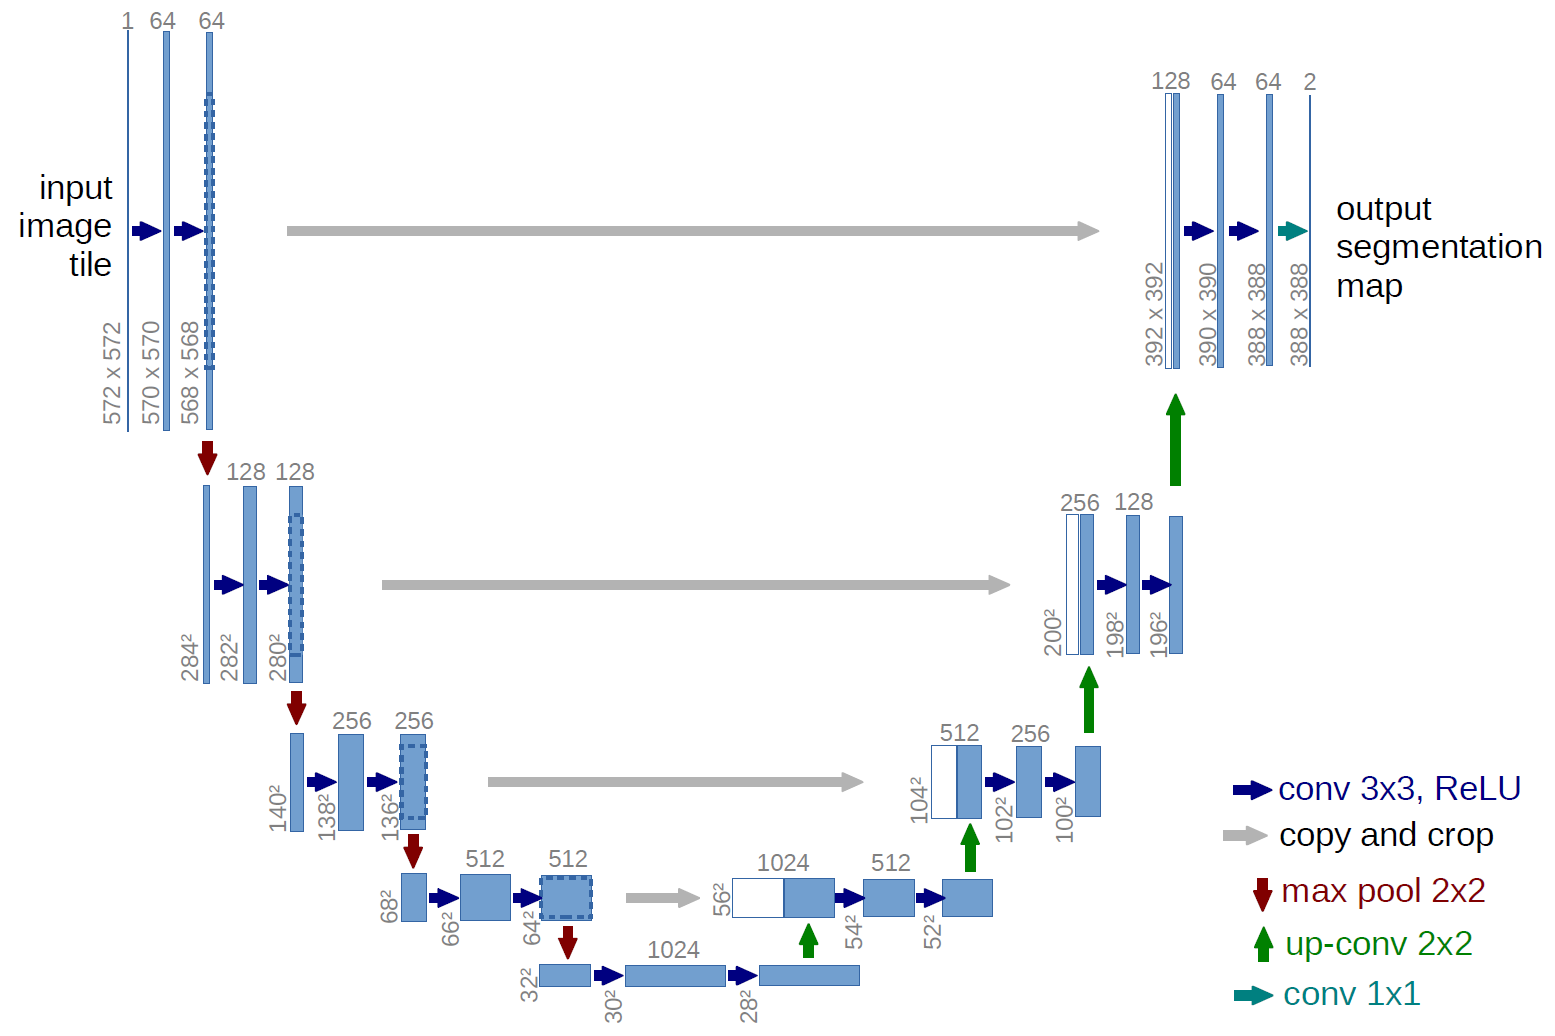

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D,Conv2DTranspose,Concatenate,Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block (inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block (inputs, 64)
    s2, p2 = encoder_block (p1, 128)
    s3, p3 = encoder_block (p2, 256)
    s4, p4 = encoder_block (p3, 512)

    b1=conv_block(p4,1024)

    d1=decoder_block(b1,s4,512)
    d2=decoder_block(d1,s3,256)
    d3=decoder_block(d2,s2,128)
    d4=decoder_block(d3,s1,64)

    outputs=Conv2D(1,1,padding="same",activation="sigmoid")(d4)

    model=Model(inputs,outputs,name="UNET")
    return model

**DRIVE VERİ SETİ**

Örnek görüntü ve maskesi̇

Gi̇rdi̇ olarak sol görüntü (512,512,3) Çıktı olarak sağ görüntü (512,512,1)

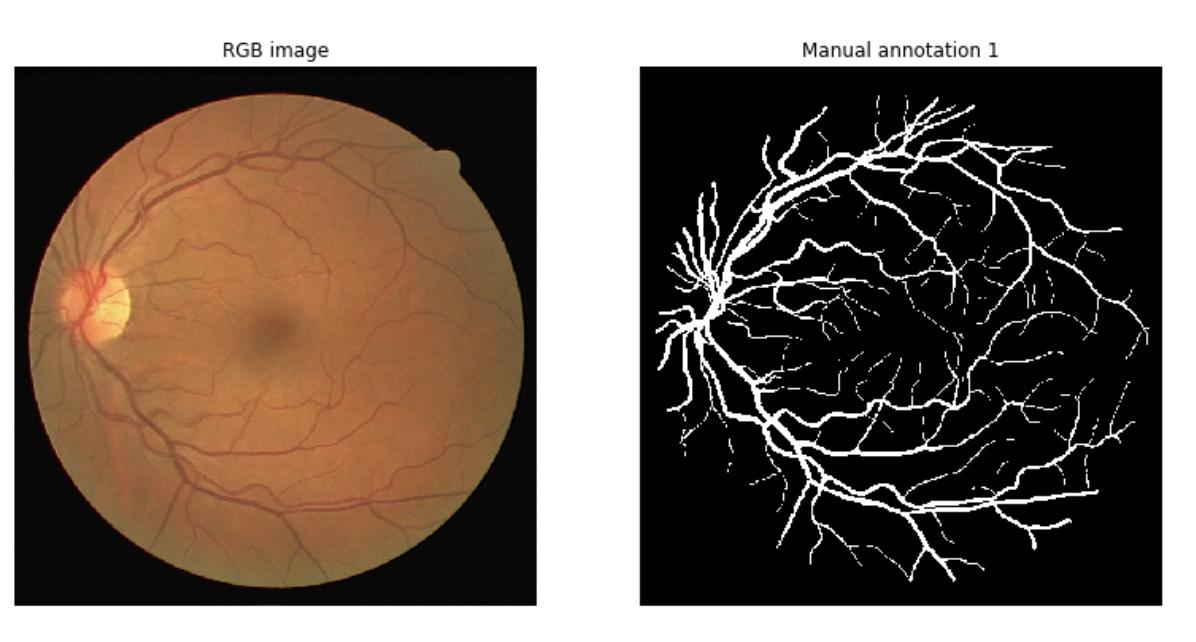


In [ ]:
input_shape=(512,512,3)
model=build_unet(input_shape)
model.summary()


Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0]

**DICE ve IoU**

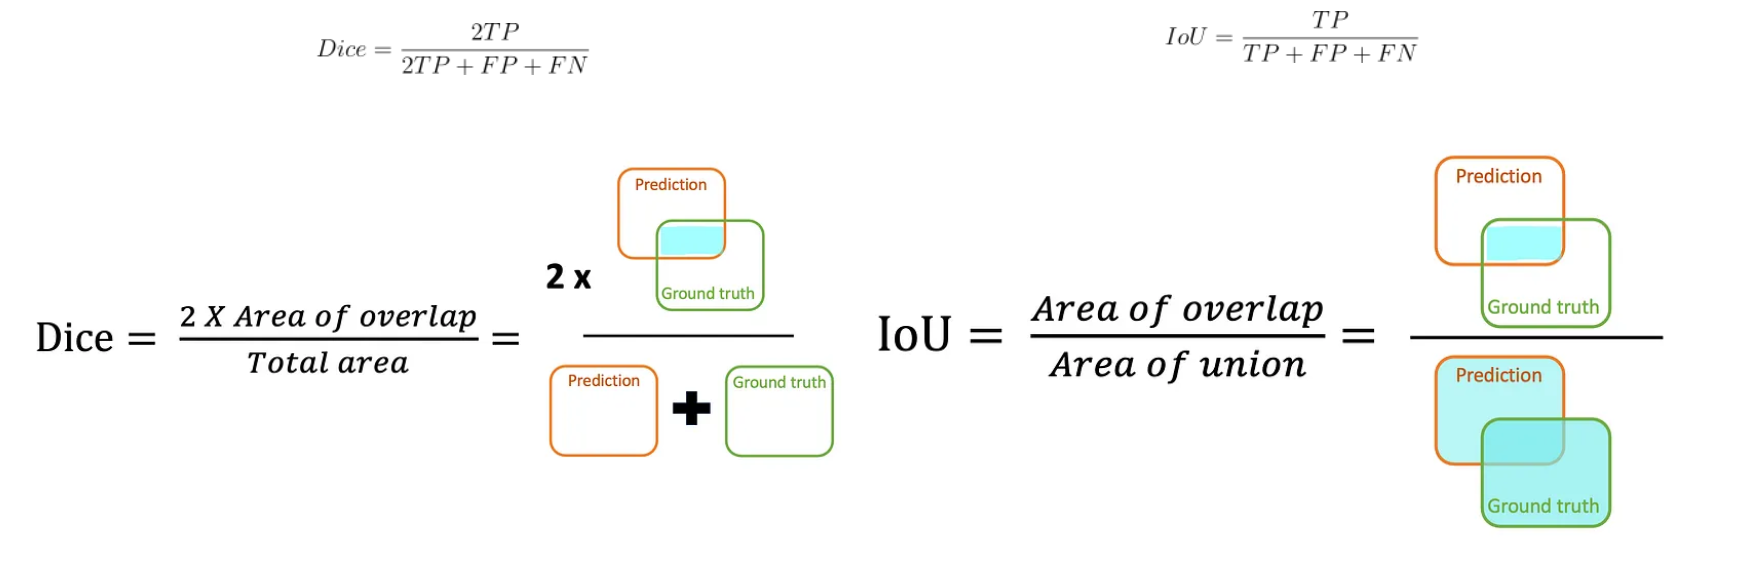

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth=K.epsilon()):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [ ]:
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

H = 512
W = 512

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)              ## (512, 512, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset


In [ ]:
%ls

DRIVE/  new_data/  Untitled0.ipynb


## MODEL TRAIN AŞAMASI

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 100
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model = build_unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
# model.summary()

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 220 - 220
Valid: 20 - 20
Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 0.6299 - dice_coef: 0.3701 - iou: 0.2329 - recall: 0.6147 - precision: 0.4266
Epoch 1: val_loss improved from inf to 0.87971, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 103s 518ms/step - loss: 0.6299 - dice_coef: 0.3701 - iou: 0.2329 - recall: 0.6147 - precision: 0.4266 - val_loss: 0.8797 - val_dice_coef: 0.1203 - val_iou: 0.0640 - val_recall: 8.9428e-07 - val_precision: 0.0400 - lr: 1.0000e-04
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 0.4577 - dice_coef: 0.5423 - iou: 0.3740 - recall: 0.4307 - precision: 0.7796
Epoch 2: val_loss did not improve from 0.87971
110/110 [==============================] - 59s 536ms/step - loss: 0.4577 - dice_coef: 0.5423 - iou: 0.3740 - recall: 0.4307 - precision: 0.7796 - val_loss: 0.9356 - val_dice_coef: 0.0644 - val_iou: 0.0333 - val_recall: 8.0932e-04 - val_precision: 0.0465 - lr: 1.0000e-04
Epoch 3/100
110/110 [==============================] - ETA: 0s - loss: 0.3967 - dice_coef: 0.6033 - iou: 0.4335 - recall: 0.4182 - precision: 0.8395
Epoch 3: val_loss improved from 0.87971 to 0.84249, saving model to files/model.h5
110/110 [====================

In [ ]:
%ls

DRIVE/  files/  logs/  new_data/  Untitled0.ipynb


In [ ]:
data_df=pd.read_csv("files/data.csv")

In [ ]:
data_df

,epoch,dice_coef,iou,loss,lr,precision,recall,val_dice_coef,val_iou,val_loss,val_precision,val_recall
0,0,0.370081,0.232851,0.629919,0.000100,0.426585,0.614705,0.120285,0.064003,0.879715,0.040000,8.942808e-07
1,1,0.542286,0.374050,0.457714,0.000100,0.779578,0.430664,0.064373,0.033259,0.935627,0.046451,8.093241e-04
2,2,0.603345,0.433490,0.396655,0.000100,0.839459,0.418217,0.157513,0.086086,0.842487,0.304582,6.093540e-02
3,3,0.640528,0.472416,0.359472,0.000100,0.871539,0.411076,0.416611,0.263985,0.583389,0.545177,2.253105e-01
4,4,0.663927,0.498312,0.336074,0.000100,0.887775,0.408225,0.586219,0.415474,0.413781,0.816504,2.950635e-01
5,5,0.692524,0.530741,0.307475,0.000100,0.908658,0.409916,0.680080,0.515901,0.319920,0.965684,3.242108e-01
6,6,0.712504,0.554395,0.287496,0.000100,0.922660,0.410922,0.709947,0.550786,0.290054,0.969146,3.351666e-01
7,7,0.728129,0.573429,0.271871,0.000100,0.931972,0.413393,0.718392,0.561067,0.281608,0.970309,3.317934e-01
8,8,0.737018,0.584453,0.262982,0.000100,0.935368,0.413429,0.731893,0.577500,0.268107,0.971329,3.386230e-01
9,9,0.745200,0.594719,0.254800,0.000100,0.939057,0.413931,0.743240,0.591760,0.256760,0.967124,3.507325e-01


## ELDE EDİLEN METRİKLERİN GÖRSELLEŞTİRİLMESİ

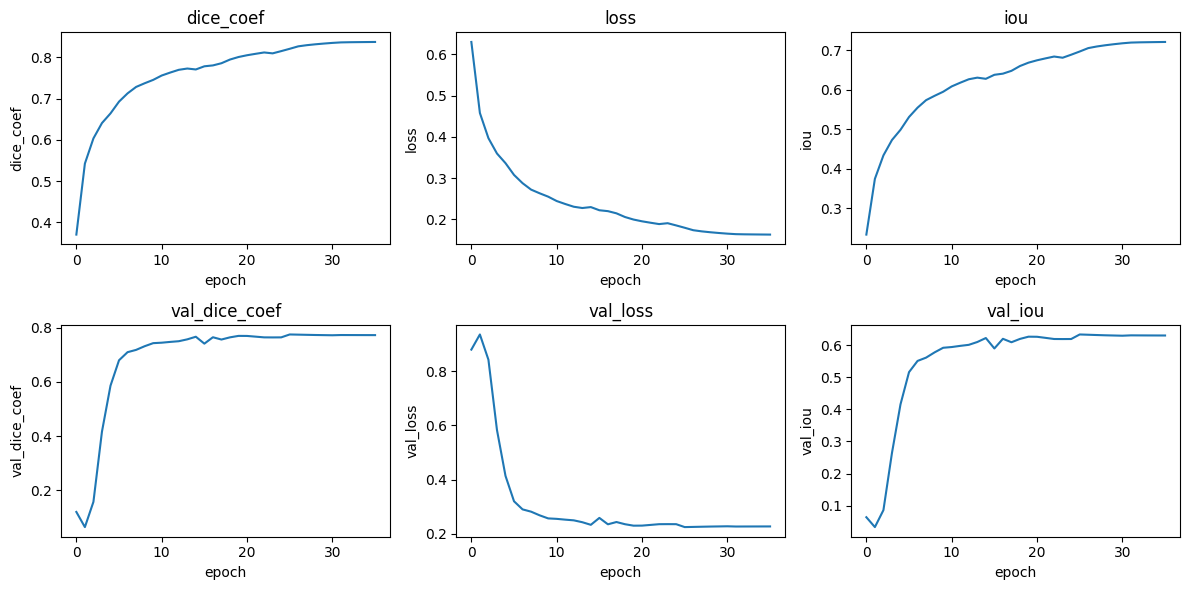

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# dice_coef
axs[0, 0].plot(data_df["epoch"], data_df["dice_coef"])
axs[0, 0].set_title("dice_coef")
axs[0, 0].set_xlabel("epoch")
axs[0, 0].set_ylabel("dice_coef")

# val_dice_coef
axs[1, 0].plot(data_df["epoch"], data_df["val_dice_coef"])
axs[1, 0].set_title("val_dice_coef")
axs[1, 0].set_xlabel("epoch")
axs[1, 0].set_ylabel("val_dice_coef")

# loss
axs[0, 1].plot(data_df["epoch"], data_df["loss"])
axs[0, 1].set_title("loss")
axs[0, 1].set_xlabel("epoch")
axs[0, 1].set_ylabel("loss")

# val_loss
axs[1, 1].plot(data_df["epoch"], data_df["val_loss"])
axs[1, 1].set_title("val_loss")
axs[1, 1].set_xlabel("epoch")
axs[1, 1].set_ylabel("val_loss")

# loss
axs[0, 2].plot(data_df["epoch"], data_df["iou"])
axs[0, 2].set_title("iou")
axs[0, 2].set_xlabel("epoch")
axs[0, 2].set_ylabel("iou")

# val_loss
axs[1, 2].plot(data_df["epoch"], data_df["val_iou"])
axs[1, 2].set_title("val_iou")
axs[1, 2].set_xlabel("epoch")
axs[1, 2].set_ylabel("val_iou")

plt.tight_layout()
plt.show()

## MODELİN TEST EDİLMESİ

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

create_dir("results")

""" Load the model """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("files/model.h5")

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


  5%|▌         | 1/20 [00:06<01:58,  6.23s/it]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 2/20 [00:07<00:54,  3.04s/it]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 3/20 [00:07<00:33,  1.98s/it]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 4/20 [00:08<00:22,  1.40s/it]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 5/20 [00:08<00:16,  1.08s/it]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 6/20 [00:09<00:12,  1.12it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 7/20 [00:09<00:09,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 8/20 [00:10<00:08,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 9/20 [00:10<00:06,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 10/20 [00:11<00:06,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 11/20 [00:11<00:05,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 12/20 [00:12<00:04,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 13/20 [00:12<00:03,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 14/20 [00:13<00:03,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 15/20 [00:13<00:02,  1.95it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 16/20 [00:14<00:02,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 17/20 [00:14<00:01,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 18/20 [00:15<00:01,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 19/20 [00:15<00:00,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

Accuracy: 0.94335
F1: 0.52291
Jaccard: 0.35483
Recall: 0.92300
Precision: 0.36697
